# Simulate CFHT Images Using HST Ones

In this notebook, we are going to simulate step by step a CFHT ground based telescope image using a HST one.

First things first, we start by preparing the workspace.

In [2]:
# to correctly show figures
%matplotlib inline

# import libraries here
import galsim
from astropy.io import fits
import numpy as np
from seeing_distribution_class import seeing_distribution
import matplotlib.pyplot as plt

Here we are going to load the CFHT and HST required parameters.
> CFHT telescope specifications can be found on [CFHT webpage](https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/generalinformation.html) (`r` filter and `Dark sky, Moon 0%` for the sky brightness) and [inside of LSST GitHub page](https://github.com/LSSTDESC/WeakLensingDeblending/blob/9f851f79f6f820f815528d11acabf64083b6e111/descwl/survey.py#L288) (for the telescope effective area).

In [3]:
pixel_scale_hst = 0.03 # HST pixel scale
pixel_scale = 0.187 # CFHT pixel scale
wcs = galsim.wcs.PixelScale(pixel_scale) #wcs: world coordinate system. Variable used to draw images in galsim
exp_time = 200 #seconds # exposure time #value corresponding to CFIS # provided by A. Guinot
sky_brightness = 21.30 #mag/arcsec^2 # for Dark sky, Moon 0%
zero_point = 10.72 #ADU/sec
cfht_eff_area = 8.022 #m^2 #effective area
qe = 0.77 # Quantum Efficiency (converts photon number to electrons)
gain = 1.62 #e-/ADU #converts electrons to ADU

Load the [COSMOS](https://github.com/GalSim-developers/GalSim/wiki/RealGalaxy%20Data) catalog and generate a galaxy and a PSF.

In [4]:
# catalog = galsim.COSMOSCatalog(dir='/gpfswork/rech/xdy/uze68md/data/COSMOS_25.2_training_sample/') # load catalog
catalog = galsim.COSMOSCatalog(dir='~/COSMOS_25.2_training_sample/') # load catalog  TO REMOVE

img_len = 64 # arbitrary value, practical because power of 2
gal_ind = 142 # galaxy index in the catalog
gal = catalog.makeGalaxy(gal_ind, noise_pad_size=img_len * pixel_scale_hst * np.sqrt(2))
seed = 1995
fwhm_sampler = seeing_distribution('seeing_distribution.npy',seed=seed)
cfht_fwhm = fwhm_sampler.get(1)[0]
psf = galsim.Kolmogorov(fwhm=cfht_fwhm,flux=1.0)#, scale_unit=galsim.arcsec) ommit units and let be handled withinin wcs

# shear the PSF
np.random.seed(seed=seed)

g_sigma = 0.01 # standard deviation of the shear distribution
def get_g(n_g):
    g = np.random.normal(0., g_sigma, n_g)
    while np.linalg.norm(g) > 1:
        g = np.random.normal(0., g_sigma, n_g)
    return g

e1, e2 = get_g(2) #+[cst1, cst2] because the mean of the PSF ellipticity can be different from zero
psf = psf.shear(g1=e1, g2=e2)

OSError: /gpfswork/rech/xdy/uze68md/data/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits not found.

In [1]:
gal

NameError: name 'gal' is not defined

Now that we have loaded a galaxy from the catalog, let's rescale its flux such that it corresponds to a CFHT flux.

> Flux rescaling formula telescope specifications can be found [here](https://github.com/GalSim-developers/GalSim/blob/releases/2.2/examples/demo11.py#L110). Additionally we need to convert the flux from $photons/cm^2/s$ to ADU , for more information check the [GalSim page on units](https://galsim-developers.github.io/GalSim/_build/html/units.html#flux-units).

In [4]:
hst_eff_area = 2.4**2 * (1.-0.33**2)
flux_scaling = (cfht_eff_area/hst_eff_area) * exp_time * qe / gain
gal *= flux_scaling

Apply the simulated CFHT PSF on the galaxy image.

In [5]:
gal = galsim.Convolve(gal, psf)

Let's have a look at the galaxy and the PSF. In the galaxy image, noted $X$, we try to visually separate the noise (which standard deviation is noted $\sigma$) from the useful signal by applying the following transform:
\begin{equation}
\text{ArcSinh}\left(\frac{X}{k\sigma}\right).k\sigma
\end{equation}
> <b>Technical precision:</b> Usually the noise standard deviation is estimated with more accurate methods such as using a window to mask the galaxy then estimate the standard deviation on the rest of the samples which only contain noise. For sake of simplicity, in this example, we considered an arbitrary area of the image that only contains noise and estimated the noise standard deviation in it.

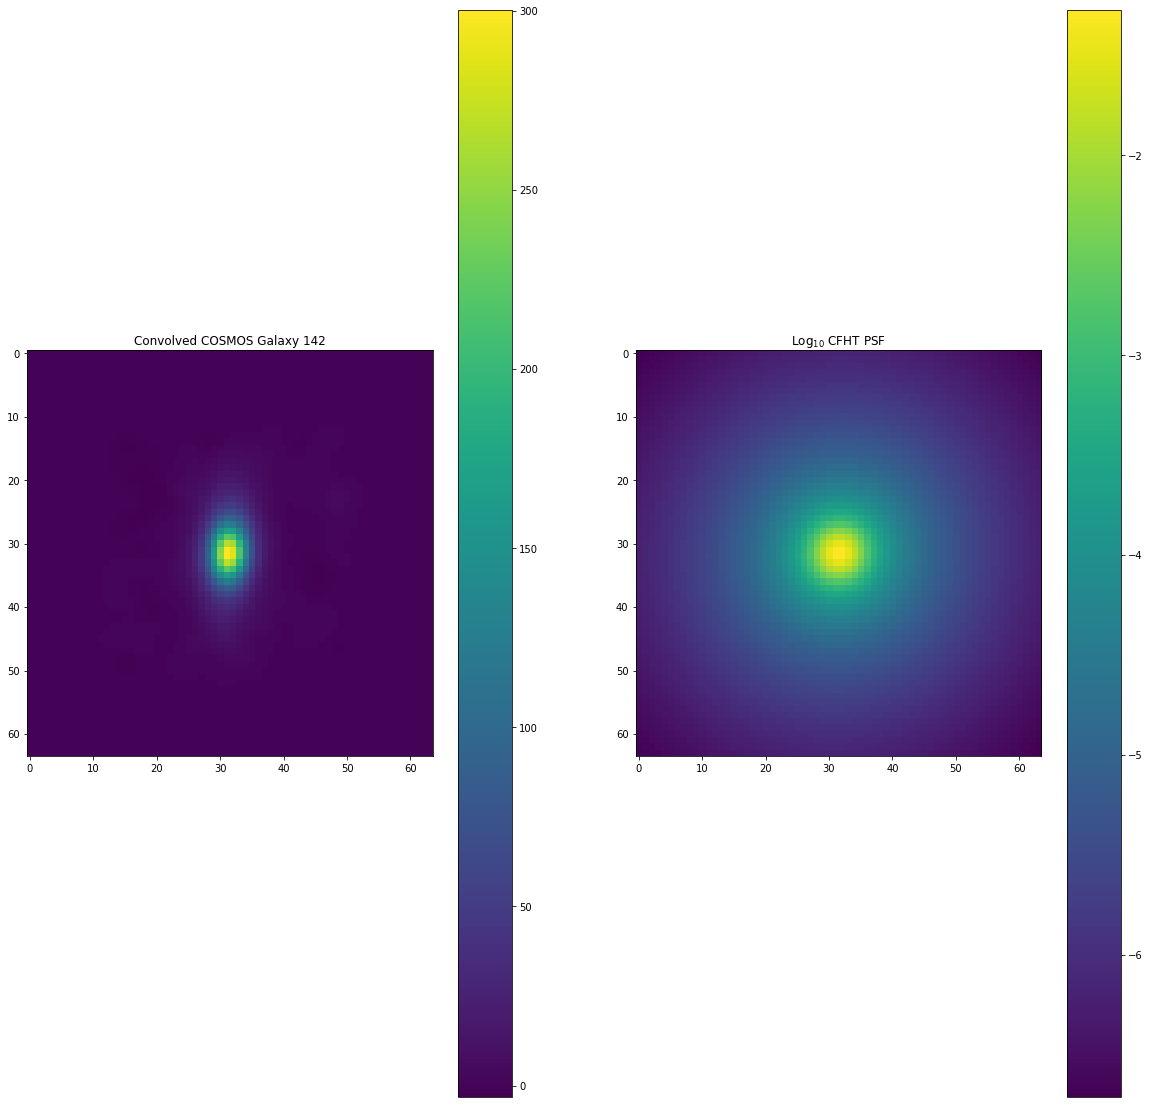

In [6]:
# Get the standard deviation value of the noise for real images
gal_im = gal.drawImage(wcs=wcs, nx=img_len,ny=img_len)
# Empirically estimate the standard deviation by considering a part of the image containing only noise
hst_std = np.std(gal_im.array[0:25,0:25])
hst_var = np.var(gal_im.array[0:25,0:25])

k=6

plt.figure(figsize=(20,20))
plt.subplot(121)
# plt.title('ArcSinh of Convolved COSMOS Galaxy {}'.format(gal_ind))
# plt.imshow(np.arcsinh(gal_im.array/(k*hst_std))*k*hst_std)
plt.title('Convolved COSMOS Galaxy {}'.format(gal_ind))
plt.imshow(gal_im.array)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log10(psf.drawImage(wcs=wcs, nx=img_len,ny=img_len).array))
plt.title(r'Log$_{10}$ CFHT PSF')
plt.colorbar()
plt.show()

The noise that we see in image above corresponds to HST noise (which is also correlated due to the division (in the Fourier space) by the HST PSF and the multiplication by the CFHT one), we are going to adapt this noise to CFHT. First we give CFHT global noise variance. Its value correspond to the `mean_sky_level`.

> The $\lambda$ parameter corresponds to the `mean_sky_level` which expression can be find [here](https://github.com/LSSTDESC/WeakLensingDeblending/blob/9f851f79f6f820f815528d11acabf64083b6e111/descwl/survey.py#L110)

In [7]:
def get_flux(ab_magnitude):
    # compared to the formula on github, we divide by the gain to convert the flux from e- to ADU
    return exp_time*zero_point*10**(-0.4*(ab_magnitude-24)) / gain


mean_sky_level = get_flux(sky_brightness) * pixel_scale ** 2
# mean_sky_level = np.sqrt(mean_sky_level_real)
print('mean_sky_level_sqrt',mean_sky_level)

sigma = np.sqrt(mean_sky_level) # we modelize the noise as a Gaussian noise such that it std
                                # is the sqrt of the Poisson parameter
print('CFHT global noise standard deviation: {:.2f}'.format(sigma))
print('HST noise standard deviation: {:.2f}'.format(hst_std))

mean_sky_level_sqrt 556.4075053722729
CFHT global noise standard deviation: 23.59
HST noise standard deviation: 0.80


Then we estimate the value of HST noise variance and we take it into to account while adding the noise such that we end up with CFHT noise variance.
> <b>Reminder:</b> For any independent random variables, the variance of the sum of those variables is equal to the sum of the variances.

In [8]:
# Add noise
delta_var = mean_sky_level - hst_var
random_seed = 24783923 #same as galsim demo 11
# noise = galsim.GaussianNoise(galsim.BaseDeviate(random_seed), sigma=delta_std)
noise = galsim.PoissonNoise(rng=galsim.BaseDeviate(random_seed), sky_level=delta_var)
gal_im.addNoise(noise)
image = gal_im.array

Now that we simulated the Euclid observed image, let's show it and estimate its noise standard deviation as a check.

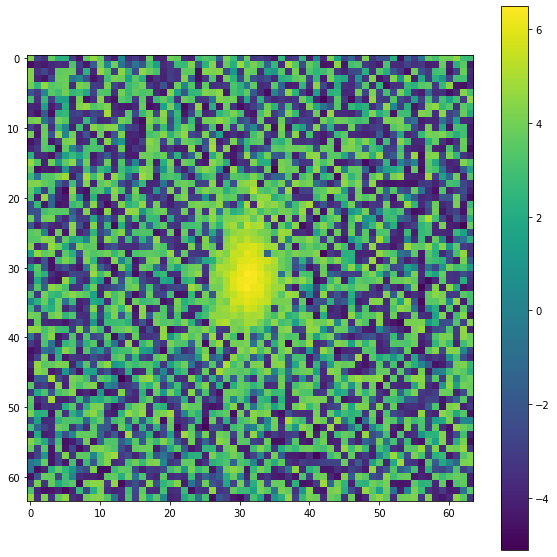

Standard Deviation Value of CFHT Simulated Image: 23.67


In [9]:
plt.figure(2, figsize=(10,10))
k=4
plt.imshow(np.arcsinh(image/(k*sigma)*k*sigma))
# plt.imshow(image)
plt.colorbar()
plt.show()
print('Standard Deviation Value of CFHT Simulated Image: {:.2f}'.format(np.std(image[0:25,0:25])))

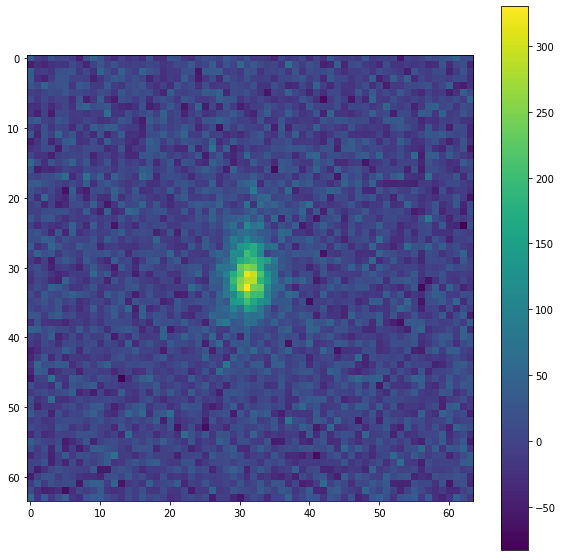

In [10]:
plt.figure(2, figsize=(10,10))
plt.imshow(image)
plt.colorbar()
plt.show()